In [1]:
# Import appropriate modules
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
from pathlib import Path
from datetime import datetime
import hvplot
import hvplot.pandas
from fbprophet import Prophet
# import plot change point function
from fbprophet.plot import add_changepoints_to_plot


In [2]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_return(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Close.pct_change()
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [3]:
# Define function to retrieve ticker daily close data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_close(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and save the Close data
        price_df = yahoo_data.history(start=start_date, end=end_date).Close
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [4]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_volume(ticker = 'spy', start_date = '2007-07-01', end_date = '2021-10-03'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Volume
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [5]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_put_options_volume(ticker = 'spy', date = '2007-07-01'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        opts = yahoo_data.option_chain()
        price_df = opts.puts
        price_df.name = ticker
        price_df = price_df.volume
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [6]:
# Set up the variable related to tickers and tickers data
ticker_data_dict = {}
ticker_list = ["^VIX", "VXX"]

# Retrieve Tickers
def retrieve_tickers(ticker_data_dict, ticker_list):
    for ticker in ticker_list:
        ticker_data = retrieve_yahoo_data_return(ticker)
        ticker_data_dict[ticker] = ticker_data
        
    return ticker_data_dict
        
ticker_data_dict = retrieve_tickers(ticker_data_dict, ticker_list)
ticker_data_df = pd.DataFrame(ticker_data_dict)
# ticker_data_df = ticker_data_df.dropna()
# Display the ticker data related data frame
ticker_data_df

Processing Ticker ^VIX
Processing Ticker VXX


^VIX       VXX
Date                          
2007-07-02       NaN       NaN
2007-07-03 -0.031169       NaN
2007-07-05  0.037533       NaN
2007-07-06 -0.049096       NaN
2007-07-09  0.029891       NaN
...              ...       ...
2021-09-27  0.056901  0.009764
2021-09-28  0.239339  0.104351
2021-09-29 -0.029677  0.014593
2021-09-30  0.025709  0.000719
2021-10-01 -0.088159 -0.036292

[3590 rows x 2 columns]

In [7]:
# check the correlation between various tickers
ticker_data_df.corr()

^VIX       VXX
^VIX  1.000000  0.886507
VXX   0.886507  1.000000

In [8]:
(1+ticker_data_df[["^VIX", "VXX"]]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [9]:
vix_data_df = ticker_data_df.drop(columns="VXX")
vix_data_df = vix_data_df.reset_index()
vix_data_df.columns = ['ds', 'y']
vix_data_df

ds         y
0    2007-07-02       NaN
1    2007-07-03 -0.031169
2    2007-07-05  0.037533
3    2007-07-06 -0.049096
4    2007-07-09  0.029891
...         ...       ...
3585 2021-09-27  0.056901
3586 2021-09-28  0.239339
3587 2021-09-29 -0.029677
3588 2021-09-30  0.025709
3589 2021-10-01 -0.088159

[3590 rows x 2 columns]

In [10]:
vix_data_df = vix_data_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_data_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [11]:
model = Prophet()
model

In [12]:
# Fit the time-series model.
model.fit(vix_data_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends = model.make_future_dataframe(periods=1000, freq='H')
future_trends

ds
0    2007-07-02 00:00:00
1    2007-07-03 00:00:00
2    2007-07-05 00:00:00
3    2007-07-06 00:00:00
4    2007-07-09 00:00:00
...                  ...
4585 2021-11-11 12:00:00
4586 2021-11-11 13:00:00
4587 2021-11-11 14:00:00
4588 2021-11-11 15:00:00
4589 2021-11-11 16:00:00

[4590 rows x 1 columns]

In [14]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)
forecast_trends

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2007-07-02 00:00:00 -0.002107   -0.094835    0.108602    -0.002107   
1    2007-07-03 00:00:00 -0.002109   -0.111575    0.098153    -0.002109   
2    2007-07-05 00:00:00 -0.002112   -0.106589    0.100053    -0.002112   
3    2007-07-06 00:00:00 -0.002113   -0.121527    0.090804    -0.002113   
4    2007-07-09 00:00:00 -0.002118   -0.093081    0.119196    -0.002118   
...                  ...       ...         ...         ...          ...   
4585 2021-11-11 12:00:00 -0.001521   -0.110046    0.104591    -0.001521   
4586 2021-11-11 13:00:00 -0.001521   -0.114742    0.097069    -0.001521   
4587 2021-11-11 14:00:00 -0.001521   -0.106244    0.094020    -0.001521   
4588 2021-11-11 15:00:00 -0.001521   -0.114677    0.103102    -0.001521   
4589 2021-11-11 16:00:00 -0.001521   -0.114079    0.099186    -0.001521   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0       -0.002107        0.013800              0.013800              0.013800   
1       -0.002109       -0.006234             -0.006234             -0.006234   
2       -0.002112       -0.004960             -0.004960             -0.004960   
3       -0.002113       -0.016615             -0.016615             -0.016615   
4       -0.002118        0.012548              0.012548              0.012548   
...           ...             ...                   ...                   ...   
4585    -0.001521       -0.005342             -0.005342             -0.005342   
4586    -0.001521       -0.005876             -0.005876             -0.005876   
4587    -0.001521       -0.006367             -0.006367             -0.006367   
4588    -0.001521       -0.006814             -0.006814             -0.006814   
4589    -0.001521       -0.007217             -0.007217             -0.007217   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     0.023056      0.023056      0.023056 -0.009256     -0.009256   
1     0.003638      0.003638      0.003638 -0.009872     -0.009872   
2     0.005728      0.005728      0.005728 -0.010687     -0.010687   
3    -0.005744     -0.005744     -0.005744 -0.010872     -0.010872   
4     0.023056      0.023056      0.023056 -0.010508     -0.010508   
...        ...           ...           ...       ...           ...   
4585 -0.002247     -0.002247     -0.002247 -0.003095     -0.003095   
4586 -0.002765     -0.002765     -0.002765 -0.003111     -0.003111   
4587 -0.003240     -0.003240     -0.003240 -0.003127     -0.003127   
4588 -0.003671     -0.003671     -0.003671 -0.003143     -0.003143   
4589 -0.004058     -0.004058     -0.004058 -0.003159     -0.003159   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.009256                   0.0                         0.0   
1        -0.009872                   0.0                         0.0   
2        -0.010687                   0.0                         0.0   
3        -0.010872                   0.0                         0.0   
4        -0.010508                   0.0                         0.0   
...            ...                   ...                         ...   
4585     -0.003095                   0.0                         0.0   
4586     -0.003111                   0.0                         0.0   
4587     -0.003127                   0.0                         0.0   
4588     -0.003143                   0.0                         0.0   
4589     -0.003159                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  0.011692  
1                            0.0 -0.008343  
2                            0.0 -0.007072  
3                            0.0 -0.018728  
4                            0.0  0.010430  
...                          ...       ...  
4585                         0.0 -0.006863  
4586                         0.0 -0.007397  
4587                         0.0 -0.0

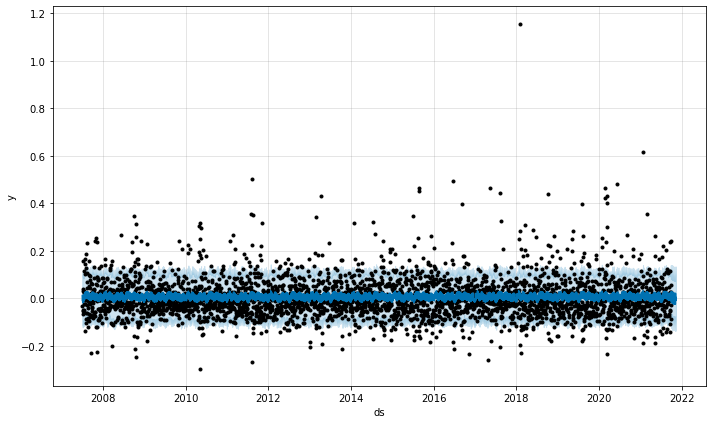

In [15]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends = model.plot(forecast_trends)

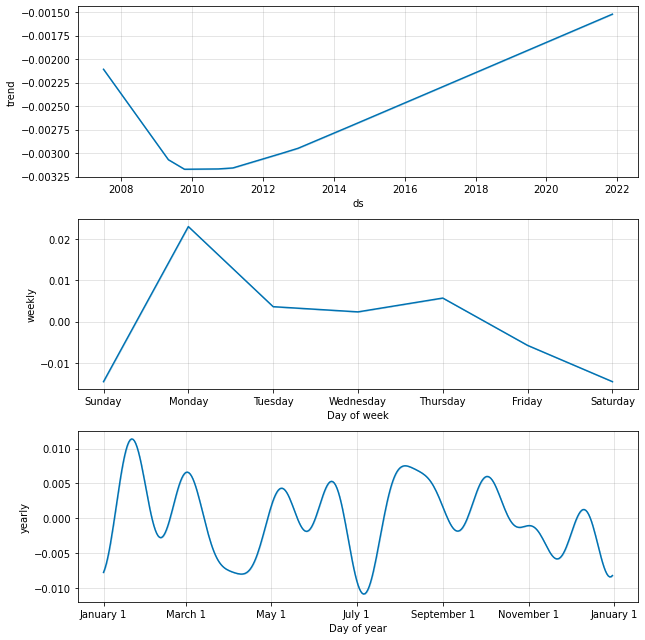

In [16]:
# Use the plot_components function to visualize the forecast results.
figures = model.plot_components(forecast_trends)

In [17]:
vix_cum_prod_df = (1+ticker_data_df[["^VIX"]]).cumprod()
vix_cum_prod_df

^VIX
Date                
2007-07-02       NaN
2007-07-03  0.968831
2007-07-05  1.005195
2007-07-06  0.955844
2007-07-09  0.984416
...              ...
2021-09-27  1.218182
2021-09-28  1.509740
2021-09-29  1.464935
2021-09-30  1.502597
2021-10-01  1.370130

[3590 rows x 1 columns]

In [18]:
vix_cum_prod_df = vix_cum_prod_df.reset_index()
vix_cum_prod_df.columns = ['ds', 'y']
vix_cum_prod_df

ds         y
0    2007-07-02       NaN
1    2007-07-03  0.968831
2    2007-07-05  1.005195
3    2007-07-06  0.955844
4    2007-07-09  0.984416
...         ...       ...
3585 2021-09-27  1.218182
3586 2021-09-28  1.509740
3587 2021-09-29  1.464935
3588 2021-09-30  1.502597
3589 2021-10-01  1.370130

[3590 rows x 2 columns]

In [19]:
vix_cum_prod_df = vix_cum_prod_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_cum_prod_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [20]:
model_cum_prod = Prophet()
model_cum_prod

In [21]:
# Fit the time-series model.
model_cum_prod.fit(vix_cum_prod_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends_cum_prod = model_cum_prod.make_future_dataframe(periods=1000, freq='H')
future_trends_cum_prod

ds
0    2007-07-02 00:00:00
1    2007-07-03 00:00:00
2    2007-07-05 00:00:00
3    2007-07-06 00:00:00
4    2007-07-09 00:00:00
...                  ...
4585 2021-11-11 12:00:00
4586 2021-11-11 13:00:00
4587 2021-11-11 14:00:00
4588 2021-11-11 15:00:00
4589 2021-11-11 16:00:00

[4590 rows x 1 columns]

In [23]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends_cum_prod = model_cum_prod.predict(future_trends_cum_prod)
forecast_trends_cum_prod

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2007-07-02 00:00:00  0.983185    0.350804    1.456572     0.983185   
1    2007-07-03 00:00:00  0.986457    0.383017    1.441223     0.986457   
2    2007-07-05 00:00:00  0.993001    0.387382    1.492583     0.993001   
3    2007-07-06 00:00:00  0.996272    0.328837    1.451104     0.996272   
4    2007-07-09 00:00:00  1.006088    0.327198    1.455308     1.006088   
...                  ...       ...         ...         ...          ...   
4585 2021-11-11 12:00:00  1.692954    1.276877    2.366038     1.692954   
4586 2021-11-11 13:00:00  1.692977    1.301135    2.366460     1.692977   
4587 2021-11-11 14:00:00  1.693000    1.288818    2.379323     1.693000   
4588 2021-11-11 15:00:00  1.693023    1.253031    2.401269     1.693023   
4589 2021-11-11 16:00:00  1.693046    1.286639    2.402530     1.693046   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        0.983185       -0.060668             -0.060668             -0.060668   
1        0.986457       -0.082206             -0.082206             -0.082206   
2        0.993001       -0.091391             -0.091391             -0.091391   
3        0.996272       -0.109218             -0.109218             -0.109218   
4        1.006088       -0.109140             -0.109140             -0.109140   
...           ...             ...                   ...                   ...   
4585     1.693255        0.125694              0.125694              0.125694   
4586     1.693282        0.125135              0.125135              0.125135   
4587     1.693309        0.124607              0.124607              0.124607   
4588     1.693336        0.124109              0.124109              0.124109   
4589     1.693363        0.123641              0.123641              0.123641   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     0.018651      0.018651      0.018651 -0.079318     -0.079318   
1     0.003406      0.003406      0.003406 -0.085613     -0.085613   
2     0.007782      0.007782      0.007782 -0.099172     -0.099172   
3    -0.002945     -0.002945     -0.002945 -0.106273     -0.106273   
4     0.018651      0.018651      0.018651 -0.127791     -0.127791   
...        ...           ...           ...       ...           ...   
4585  0.000860      0.000860      0.000860  0.124834      0.124834   
4586  0.000400      0.000400      0.000400  0.124736      0.124736   
4587 -0.000030     -0.000030     -0.000030  0.124637      0.124637   
4588 -0.000430     -0.000430     -0.000430  0.124539      0.124539   
4589 -0.000799     -0.000799     -0.000799  0.124440      0.124440   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.079318                   0.0                         0.0   
1        -0.085613                   0.0                         0.0   
2        -0.099172                   0.0                         0.0   
3        -0.106273                   0.0                         0.0   
4        -0.127791                   0.0                         0.0   
...            ...                   ...                         ...   
4585      0.124834                   0.0                         0.0   
4586      0.124736                   0.0                         0.0   
4587      0.124637                   0.0                         0.0   
4588      0.124539                   0.0                         0.0   
4589      0.124440                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  0.922517  
1                            0.0  0.904251  
2                            0.0  0.901610  
3                            0.0  0.887055  
4                            0.0  0.896948  
...                          ...       ...  
4585                         0.0  1.818648  
4586                         0.0  1.818113  
4587                         0.0  1.8

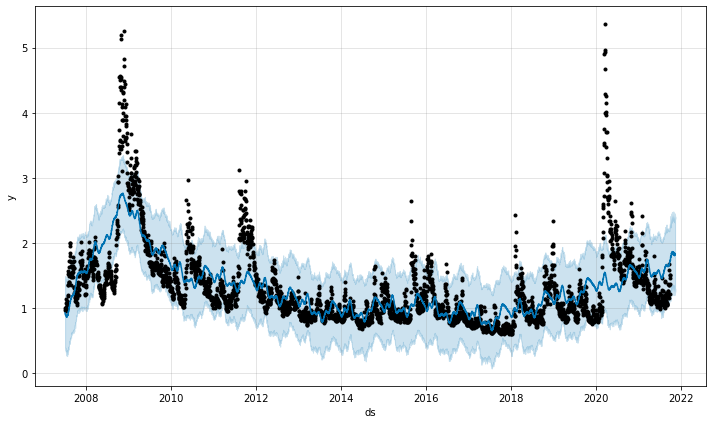

In [24]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

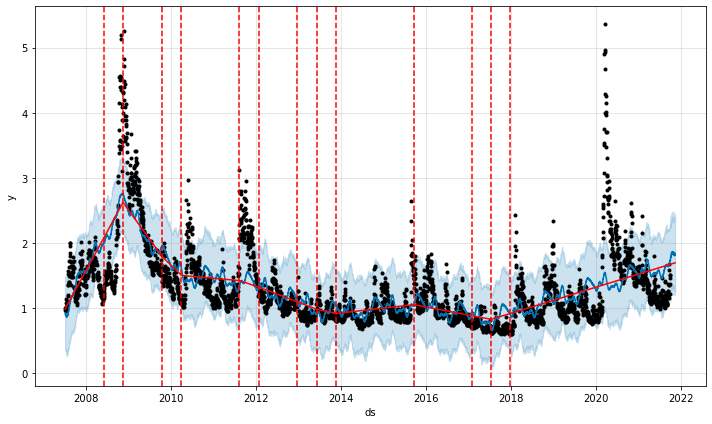

In [25]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

# add change points to plot; by default changepoints are only inferred for the first 80% of data to avoid overfitting,
# but this can be changed by using the changepoint_range argument of the model
a = add_changepoints_to_plot(plot_forecast_trends_cum_prod.gca(),
                             model_cum_prod,
                             forecast_trends_cum_prod,
                             trend=True)

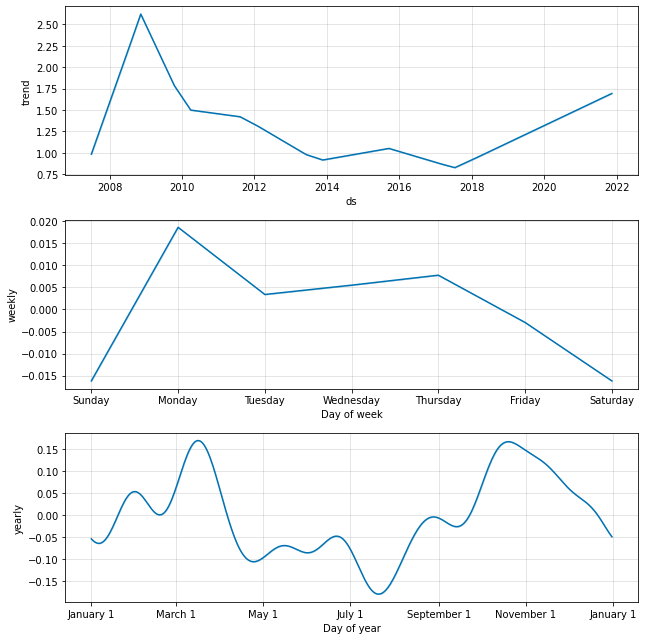

In [26]:
# Use the plot_components function to visualize the forecast results.
figures_cum_prod = model_cum_prod.plot_components(forecast_trends_cum_prod)

In [27]:
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.day_name())), axis=1)
vix_data_df.head()

ds         y  Friday  Monday  Thursday  Tuesday  Wednesday
0 2007-07-02       NaN       0       1         0        0          0
1 2007-07-03 -0.031169       0       0         0        1          0
2 2007-07-05  0.037533       0       0         1        0          0
3 2007-07-06 -0.049096       1       0         0        0          0
4 2007-07-09  0.029891       0       1         0        0          0

In [28]:
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.month_name())), axis=1)
vix_data_df.head()

ds         y  Friday  Monday  Thursday  Tuesday  Wednesday  April  \
0 2007-07-02       NaN       0       1         0        0          0      0   
1 2007-07-03 -0.031169       0       0         0        1          0      0   
2 2007-07-05  0.037533       0       0         1        0          0      0   
3 2007-07-06 -0.049096       1       0         0        0          0      0   
4 2007-07-09  0.029891       0       1         0        0          0      0   

   August  December  February  January  July  June  March  May  November  \
0       0         0         0        0     1     0      0    0         0   
1       0         0         0        0     1     0      0    0         0   
2       0         0         0        0     1     0      0    0         0   
3       0         0         0        0     1     0      0    0         0   
4       0         0         0        0     1     0      0    0         0   

   October  September  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0

In [29]:
vix_data_df.corr()

y    Friday    Monday  Thursday   Tuesday  Wednesday  \
y          1.000000 -0.067741  0.101298  0.001272 -0.012236  -0.019951   
Friday    -0.067741  1.000000 -0.240823 -0.251305 -0.253911  -0.253911   
Monday     0.101298 -0.240823  1.000000 -0.242080 -0.244591  -0.244591   
Thursday   0.001272 -0.251305 -0.242080  1.000000 -0.255237  -0.255237   
Tuesday   -0.012236 -0.253911 -0.244591 -0.255237  1.000000  -0.257884   
Wednesday -0.019951 -0.253911 -0.244591 -0.255237 -0.257884   1.000000   
April     -0.016436 -0.021399  0.013075  0.005364  0.000343   0.002867   
August     0.017660  0.001926  0.011507 -0.001807 -0.006820  -0.004435   
December   0.000233 -0.007607  0.011548  0.001282 -0.001204  -0.003716   
February   0.004928  0.008464 -0.020711  0.004615  0.002231   0.004852   
January    0.010851  0.008786 -0.027205  0.010117  0.002512   0.005072   
July      -0.007894 -0.004405  0.004838  0.001627  0.001456  -0.003394   
June       0.004556 -0.002516  0.011611 -0.003766 -0.001257  -0.003750   
March     -0.012656 -0.009990  0.014229 -0.001269  0.001165  -0.003784   
May        0.002894  0.010667 -0.021724  0.006858  0.001827   0.001827   
November  -0.016859  0.010304  0.016694 -0.029470  0.001457   0.001457   
October    0.006022  0.001981  0.006176  0.000692 -0.006768  -0.001863   
September  0.006014  0.004489 -0.021995  0.005690  0.005599   0.005599   

              April    August  December  February   January      July  \
y         -0.016436  0.017660  0.000233  0.004928  0.010851 -0.007894   
Friday    -0.021399  0.001926 -0.007607  0.008464  0.008786 -0.004405   
Monday     0.013075  0.011507  0.011548 -0.020711 -0.027205  0.004838   
Thursday   0.005364 -0.001807  0.001282  0.004615  0.010117  0.001627   
Tuesday    0.000343 -0.006820 -0.001204  0.002231  0.002512  0.001456   
Wednesday  0.002867 -0.004435 -0.003716  0.004852  0.005072 -0.003394   
April      1.000000 -0.094828 -0.089033 -0.084685 -0.087045 -0.092923   
August    -0.094828  1.000000 -0.095358 -0.090701 -0.093228 -0.099524   
December  -0.089033 -0.095358  1.000000 -0.085158 -0.087531 -0.093441   
February  -0.084685 -0.090701 -0.085158  1.000000 -0.083256 -0.088879   
January   -0.087045 -0.093228 -0.087531 -0.083256  1.000000 -0.091355   
July      -0.092923 -0.099524 -0.093441 -0.088879 -0.091355  1.000000   
June      -0.089852 -0.096235 -0.090354 -0.085942 -0.088336 -0.094301   
March     -0.090667 -0.097108 -0.091173 -0.086721 -0.089137 -0.095156   
May       -0.088868 -0.095181 -0.089364 -0.085001 -0.087369 -0.093269   
November  -0.087378 -0.093585 -0.087866 -0.083575 -0.085904 -0.091705   
October   -0.091638 -0.098148 -0.092149 -0.087650 -0.090092 -0.096176   
September -0.090829 -0.097282 -0.091336 -0.086876 -0.089297 -0.095327   

               June     March       May  November   October  September  
y          0.004556 -0.012656  0.002894 -0.016859  0.006022   0.006014  
Friday    -0.002516 -0.009990  0.010667  0.010304  0.001981   0.004489  
Monday     0.011611  0.014229 -0.021724  0.016694  0.006176  -0.021995  
Thursday  -0.003766 -0.001269  0.006858 -0.029470  0.000692   0.005690  
Tuesday   -0.001257  0.001165  0.001827  0.001457 -0.006768   0.005599  
Wednesday -0.003750 -0.003784  0.001827  0.001457 -0.001863   0.005599  
April     -0.089852 -0.090667 -0.088868 -0.087378 -0.091638  -0.090829  
August    -0.096235 -0.097108 -0.095181 -0.093585 -0.098148  -0.097282  
December  -0.090354 -0.091173 -0.089364 -0.087866 -0.092149  -0.091336  
February  -0.085942 -0.086721 -0.085001 -0.083575 -0.087650  -0.086876  
January   -0.088336 -0.089137 -0.087369 -0.085904 -0.090092  -0.089297  
July      -0.094301 -0.095156 -0.093269 -0.091705 -0.096176  -0.095327  
June       1.000000 -0.092012 -0.090187 -0.088675 -0.092998  -0.092177  
March     -0.092012  1.000000 -0.091004 -0.089479 -0.093841  -0.093013  
May       -0.090187 -0.091004  1.000000 -0.087703 -0.091979  -0.091167  
November  -0.088675 -0.089479 -0.087703  1.000000 -0.09

In [30]:
vix_data_df = vix_data_df.drop(columns=["Tuesday", "Wednesday", "Thursday"])
vix_data_df

ds         y  Friday  Monday  April  August  December  February  \
0    2007-07-02       NaN       0       1      0       0         0         0   
1    2007-07-03 -0.031169       0       0      0       0         0         0   
2    2007-07-05  0.037533       0       0      0       0         0         0   
3    2007-07-06 -0.049096       1       0      0       0         0         0   
4    2007-07-09  0.029891       0       1      0       0         0         0   
...         ...       ...     ...     ...    ...     ...       ...       ...   
3585 2021-09-27  0.056901       0       1      0       0         0         0   
3586 2021-09-28  0.239339       0       0      0       0         0         0   
3587 2021-09-29 -0.029677       0       0      0       0         0         0   
3588 2021-09-30  0.025709       0       0      0       0         0         0   
3589 2021-10-01 -0.088159       1       0      0       0         0         0   

      January  July  June  March  May  November  October  September  
0           0     1     0      0    0         0        0          0  
1           0     1     0      0    0         0        0          0  
2           0     1     0      0    0         0        0          0  
3           0     1     0      0    0         0        0          0  
4           0     1     0      0    0         0        0          0  
...       ...   ...   ...    ...  ...       ...      ...        ...  
3585        0     0     0      0    0         0        0          1  
3586        0     0     0      0    0         0        0          1  
3587        0     0     0      0    0         0        0          1  
3588        0     0     0      0    0         0        0          1  
3589        0     0     0      0    0         0        1          0  

[3590 rows x 16 columns]

In [31]:
vix_data_df = vix_data_df.drop(columns=["April", "August", "December", "February", "January", "July", "June", "March", "May", "November", "October", "September"])
vix_data_df

ds         y  Friday  Monday
0    2007-07-02       NaN       0       1
1    2007-07-03 -0.031169       0       0
2    2007-07-05  0.037533       0       0
3    2007-07-06 -0.049096       1       0
4    2007-07-09  0.029891       0       1
...         ...       ...     ...     ...
3585 2021-09-27  0.056901       0       1
3586 2021-09-28  0.239339       0       0
3587 2021-09-29 -0.029677       0       0
3588 2021-09-30  0.025709       0       0
3589 2021-10-01 -0.088159       1       0

[3590 rows x 4 columns]

In [32]:
vix_data_df.columns = ["date", "close", "Friday", "Monday"]
# vix_data_df = vix_data_df.set_index("date")
vix_data_df

date     close  Friday  Monday
0    2007-07-02       NaN       0       1
1    2007-07-03 -0.031169       0       0
2    2007-07-05  0.037533       0       0
3    2007-07-06 -0.049096       1       0
4    2007-07-09  0.029891       0       1
...         ...       ...     ...     ...
3585 2021-09-27  0.056901       0       1
3586 2021-09-28  0.239339       0       0
3587 2021-09-29 -0.029677       0       0
3588 2021-09-30  0.025709       0       0
3589 2021-10-01 -0.088159       1       0

[3590 rows x 4 columns]

In [34]:
vix_data_df.to_csv('prophet_output.csv', index=False)  